In [16]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import interp

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier as KNN

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import make_scorer

from sklearn.dummy import DummyClassifier

# Load data

In [2]:
emotion_labels = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4:'sad', 5:'surprise', 6:'neutral'}
target_labels = [val for key, val in emotion_labels.items()]
targets = [key for key, val in emotion_labels.items()]

In [3]:
def load_data(df, data_type):
    """Load data from DataFrame and return data to list 
    """
    image_data = []
    image_scaled = []
    
    for index, row in df.iterrows():
        if data_type == 1:
            field = row.pca
        elif data_type == 2:
            field = row.histogram
        elif data_type == 3:
            field = row.hog
        elif data_type == 4:
            field = row.lda
        else:
            field = row.pixels
        image = np.fromstring(field, sep=' ')
        image_data.append(image)
        if data_type == 0:
            scale = image / 255.0
            image_scaled.append(scale)
        
    return image_data, image_scaled

# Grid Search with PCA data

Find out the good tuning for hyper parameter with PCA data because it takes long time to get result with original data.

In [151]:
df = pd.read_csv('data/pca/fer_pca.csv')
df.head()

,usage,emotion,pca
0,train,3,-0.4589713258466278 0.962093546388383 -0.55788...
1,train,3,0.49198604184990685 -1.0021801630235339 0.2740...
2,train,3,-0.9419501076570959 1.4385249489843621 0.29373...
3,train,3,-1.2800578618783192 0.23932335345423272 0.4704...
4,train,3,0.10681625087574084 -0.7089926999517396 0.3826...


In [152]:
df_train = df[df['usage']=='train']
df_test = df[df['usage']=='test']
train_data, train_scaled = load_data(df_train, 1)
train_target = list(df_train.emotion)
test_data, test_scaled = load_data(df_test, 1)
test_target = list(df_test.emotion)

In [153]:
X_train = np.array(train_data)
y_train = np.array(train_target)
X_test = np.array(test_data)
y_test = np.array(test_target)

In [154]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(31432, 103)
(31432,)
(7896, 103)
(7896,)


## Find out which hyper parameters are best

In [155]:
param_grid = [{'n_neighbors': [3, 5, 10, 15, 20, 25],
               'weights': ['uniform', 'distance'], 
               'metric': ['minkowski', 'euclidean', 'manhattan']}]

knn = KNN()

gs = GridSearchCV(estimator=knn, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  refit=True,
                  cv=10,
                  n_jobs=-1)
clf = gs.fit(X_train, y_train)

In [156]:
print(clf.best_score_)
print(clf.best_params_)
result = clf.best_estimator_
print('Test accuracy: %.3f' % result.score(X_test, y_test))

0.43983859078577625
{'metric': 'minkowski', 'n_neighbors': 3, 'weights': 'distance'}
Test accuracy: 0.449


Following comparison use n_neighbors as 3, distance weights, and minkowski metric.

# KNN with original dataset

In [58]:
df = pd.read_csv('data/fer_data.csv')
df.head()

,usage,emotion,pixels
0,train,3,108 83 63 65 89 111 121 121 125 111 103 105 11...
1,train,3,137 142 159 162 158 134 113 167 174 177 164 12...
2,train,3,111 148 155 167 181 191 194 193 195 199 203 20...
3,train,3,151 156 121 100 80 116 151 169 183 185 192 190...
4,train,3,248 187 149 130 97 140 139 117 197 251 231 255...


In [59]:
df_train = df[df['usage']=='train']
df_test = df[df['usage']=='test']
train_data, train_scaled = load_data(df_train, 0)
train_target = list(df_train.emotion)
test_data, test_scaled = load_data(df_test, 0)
test_target = list(df_test.emotion)

In [60]:
X_train = np.array(train_data)
y_train = np.array(train_target)
X_test = np.array(test_data)
y_test = np.array(test_target)

In [61]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(31432, 2304)
(31432,)
(7896, 2304)
(7896,)


In [62]:
knn = KNN(n_neighbors=3, weights='distance', metric='minkowski')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print('Test Accuracy: %.3f' % knn.score(X_test, y_test))

Test Accuracy: 0.452


In [63]:
orig_predictions = [y_pred]
orig_actuals = [y_test]

In [64]:
# Scaled data
X_train = np.array(train_scaled)
y_train = np.array(train_target)
X_test = np.array(test_scaled)
y_test = np.array(test_target)

In [65]:
knn = KNN(n_neighbors=3, weights='distance', metric='minkowski')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print('Test Accuracy: %.3f' % knn.score(X_test, y_test))

Test Accuracy: 0.452


In [66]:
orig_predictions.append(y_pred)
orig_actuals.append(y_test)

## Evaluation

### Confusion matrix

In [10]:
def show_confusion_matrix(confmat):
    """Display confusion matrix with percent values 
    """
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            percent = "{:.2f}".format(confmat[i, j])
            ax.text(x=j, y=i, s=percent+'%', va='center', ha='center')


    ax.set_xticklabels([''] + target_labels)
    ax.set_yticklabels([''] + target_labels)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.tight_layout()
    plt.show()

C:\Users\CREATE\AppData\Local\Temp\ipykernel_11344\3629548759.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + target_labels)
C:\Users\CREATE\AppData\Local\Temp\ipykernel_11344\3629548759.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + target_labels)


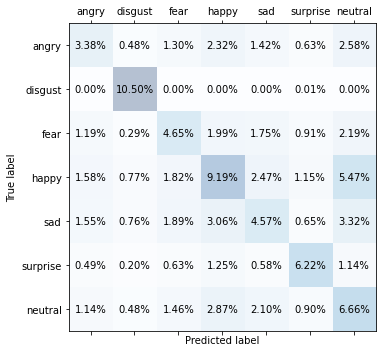

In [102]:
i = 0
confmat = confusion_matrix(y_true=orig_actuals[i], y_pred=orig_predictions[i], labels=targets)
confmat = confmat/np.sum(confmat) * 100
show_confusion_matrix(confmat)

### Parformance matrics & Classification reports

In [69]:
i = 0
print('Precision: %.3f' % precision_score(y_true=orig_actuals[i], y_pred=orig_predictions[i], average='macro'))
print('Recall: %.3f' % recall_score(y_true=orig_actuals[i], y_pred=orig_predictions[i], average='macro'))
print('F1: %.3f' % f1_score(y_true=orig_actuals[i], y_pred=orig_predictions[i], average='macro'))
print('Accuracy: %.3f' % accuracy_score(y_true=orig_actuals[i], y_pred=orig_predictions[i]))
print(classification_report(y_true=orig_actuals[i], y_pred=orig_predictions[i], target_names=target_labels))

Precision: 0.463
Recall: 0.479
F1: 0.466
Accuracy: 0.452
              precision    recall  f1-score   support

       angry       0.36      0.28      0.32       957
     disgust       0.78      1.00      0.87       830
        fear       0.40      0.36      0.38      1024
       happy       0.44      0.41      0.43      1774
         sad       0.35      0.29      0.32      1247
    surprise       0.59      0.59      0.59       831
     neutral       0.31      0.43      0.36      1233

    accuracy                           0.45      7896
   macro avg       0.46      0.48      0.47      7896
weighted avg       0.44      0.45      0.44      7896



In [70]:
i = 1
print('Precision: %.3f' % precision_score(y_true=orig_actuals[i], y_pred=orig_predictions[i], average='macro'))
print('Recall: %.3f' % recall_score(y_true=orig_actuals[i], y_pred=orig_predictions[i], average='macro'))
print('F1: %.3f' % f1_score(y_true=orig_actuals[i], y_pred=orig_predictions[i], average='macro'))
print('Accuracy: %.3f' % accuracy_score(y_true=orig_actuals[i], y_pred=orig_predictions[i]))
print(classification_report(y_true=orig_actuals[i], y_pred=orig_predictions[i], target_names=target_labels))

Precision: 0.463
Recall: 0.479
F1: 0.466
Accuracy: 0.452
              precision    recall  f1-score   support

       angry       0.36      0.28      0.32       957
     disgust       0.78      1.00      0.87       830
        fear       0.40      0.36      0.38      1024
       happy       0.44      0.41      0.43      1774
         sad       0.35      0.29      0.32      1247
    surprise       0.59      0.59      0.59       831
     neutral       0.31      0.43      0.36      1233

    accuracy                           0.45      7896
   macro avg       0.46      0.48      0.47      7896
weighted avg       0.44      0.45      0.44      7896



# KNN with PCA

In [8]:
def processKNN(csv, data_type):
    """Process KNN for each csv data
    """
    print(csv)
    df = pd.read_csv(csv)
    df.head()
    
    df_train = df[df['usage']=='train']
    df_test = df[df['usage']=='test']
    train_data, train_scaled = load_data(df_train, data_type)
    train_target = list(df_train.emotion)
    test_data, test_scaled = load_data(df_test, data_type)
    test_target = list(df_test.emotion)
    
    X_train = np.array(train_data)
    y_train = np.array(train_target)
    X_test = np.array(test_data)
    y_test = np.array(test_target)
    
    print(X_train.shape)
    print(y_train.shape)
    print(X_test.shape)
    print(y_test.shape)
    
    knn = KNN(n_neighbors=3, weights='distance', metric='minkowski')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    print('Test Accuracy: %.3f' % knn.score(X_test, y_test))
    
    return y_pred, y_test

In [115]:
csv_list = ['data/pca/fer_pca.csv', 'data/pca/fer_pca_inverse.csv', 'data/pca/fer_pca_norm.csv', 
            'data/pca/fer_pca_std.csv', 'data/pca/fer_pca_scaled.csv']

In [76]:
pca_predictions = []
pca_actuals = []
for i in range(len(csv_list)):
    pred, act = processKNN(csv_list[i], 1)
    pca_predictions.append(pred)
    pca_actuals.append(act)

data/pca/fer_pca.csv
(31432, 103)
(31432,)
(7896, 103)
(7896,)
Test Accuracy: 0.449
data/pca/fer_pca_inverse.csv
(31432, 2304)
(31432,)
(7896, 2304)
(7896,)
Test Accuracy: 0.465
data/pca/fer_pca_norm.csv
(31432, 157)
(31432,)
(7896, 157)
(7896,)
Test Accuracy: 0.437
data/pca/fer_pca_std.csv
(31432, 112)
(31432,)
(7896, 112)
(7896,)
Test Accuracy: 0.460
data/pca/fer_pca_scaled.csv
(31432, 103)
(31432,)
(7896, 103)
(7896,)
Test Accuracy: 0.449


## Evaluation

### Confusion matrix

C:\Users\CREATE\AppData\Local\Temp\ipykernel_11344\3629548759.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + target_labels)
C:\Users\CREATE\AppData\Local\Temp\ipykernel_11344\3629548759.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + target_labels)


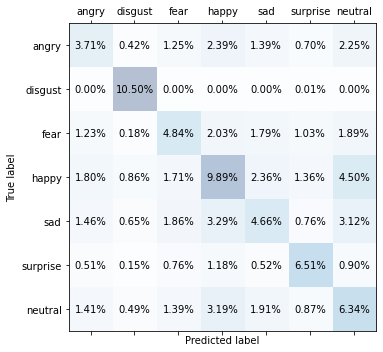

In [103]:
# Show only the best one 
i = 1
confmat = confusion_matrix(y_true=pca_actuals[i], y_pred=pca_predictions[i], labels=targets)
confmat = confmat/np.sum(confmat) * 100
show_confusion_matrix(confmat)

### Performance matrics & Classification reports

In [5]:
def showPerformance(predictions, actuals):
    """Display performance of each result
    """
    for i in range(len(csv_list)):
        print(csv_list[i])
        print('Precision: %.3f' % precision_score(y_true=actuals[i], y_pred=predictions[i], average='macro'))
        print('Recall: %.3f' % recall_score(y_true=actuals[i], y_pred=predictions[i], average='macro'))
        print('F1: %.3f' % f1_score(y_true=actuals[i], y_pred=predictions[i], average='macro'))
        print('Accuracy: %.3f' % accuracy_score(y_true=actuals[i], y_pred=predictions[i]))
        print('Classification reports')
        print(classification_report(actuals[i], predictions[i], target_names=list(target_labels)))

In [116]:
showPerformance(pca_predictions, pca_actuals)

data/pca/fer_pca.csv
Precision: 0.465
Recall: 0.475
F1: 0.462
Accuracy: 0.449
Classification reports
              precision    recall  f1-score   support

       angry       0.37      0.26      0.31       957
     disgust       0.77      1.00      0.87       830
        fear       0.36      0.35      0.36      1024
       happy       0.50      0.40      0.45      1774
         sad       0.36      0.29      0.32      1247
    surprise       0.59      0.57      0.58       831
     neutral       0.29      0.46      0.35      1233

    accuracy                           0.45      7896
   macro avg       0.47      0.48      0.46      7896
weighted avg       0.45      0.45      0.44      7896

data/pca/fer_pca_inverse.csv
Precision: 0.472
Recall: 0.491
F1: 0.478
Accuracy: 0.465
Classification reports
              precision    recall  f1-score   support

       angry       0.37      0.31      0.33       957
     disgust       0.79      1.00      0.88       830
        fear       0.41      0

# KNN with FisherFace

In [55]:
csv_list = ['data/lda/fer_lda.csv', 'data/lda/fer_lda_norm.csv', 'data/lda/fer_lda_std.csv', 'data/lda/fer_lda_scaled.csv']

In [58]:
lda_predictions = []
lda_actuals = []
for i in range(len(csv_list)):
    pred, act = processKNN(csv_list[i], 4)
    lda_predictions.append(pred)
    lda_actuals.append(act)

data/lda/fer_lda.csv
(31432, 6)
(31432,)
(7896, 6)
(7896,)
Test Accuracy: 0.417
data/lda/fer_lda_norm.csv
(31432, 6)
(31432,)
(7896, 6)
(7896,)
Test Accuracy: 0.414
data/lda/fer_lda_std.csv
(31432, 6)
(31432,)
(7896, 6)
(7896,)
Test Accuracy: 0.422
data/lda/fer_lda_scaled.csv
(31432, 6)
(31432,)
(7896, 6)
(7896,)
Test Accuracy: 0.418


## Evaluation

### Confusion matrix

C:\Users\CREATE\AppData\Local\Temp\ipykernel_3524\3629548759.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + target_labels)
C:\Users\CREATE\AppData\Local\Temp\ipykernel_3524\3629548759.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + target_labels)


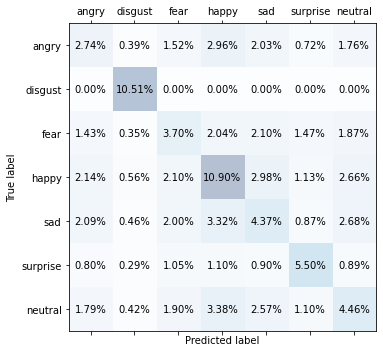

In [59]:
# Show only the best one 
i = 2
confmat = confusion_matrix(y_true=lda_actuals[i], y_pred=lda_predictions[i], labels=targets)
confmat = confmat/np.sum(confmat) * 100
show_confusion_matrix(confmat)

### Parformance matrics & Classification reports

In [60]:
showPerformance(lda_predictions, lda_actuals)

data/lda/fer_lda.csv
Precision: 0.416
Recall: 0.437
F1: 0.426
Accuracy: 0.417
Classification reports
              precision    recall  f1-score   support

       angry       0.25      0.25      0.25       957
     disgust       0.83      1.00      0.91       830
        fear       0.27      0.26      0.27      1024
       happy       0.47      0.47      0.47      1774
         sad       0.29      0.26      0.28      1247
    surprise       0.49      0.52      0.51       831
     neutral       0.31      0.30      0.31      1233

    accuracy                           0.42      7896
   macro avg       0.42      0.44      0.43      7896
weighted avg       0.40      0.42      0.41      7896

data/lda/fer_lda_norm.csv
Precision: 0.412
Recall: 0.435
F1: 0.422
Accuracy: 0.414
Classification reports
              precision    recall  f1-score   support

       angry       0.26      0.25      0.25       957
     disgust       0.81      1.00      0.89       830
        fear       0.29      0.28

# KNN with SIFT

In [117]:
csv_list = ['data/sift/sift_bof_100.csv', 'data/sift/sift_bof_500.csv', 'data/sift/sift_bof_1000.csv', 
            'data/sift/sift_pca_bof_100.csv', 'data/sift/sift_pca_bof_500.csv', 'data/sift/sift_pca_bof_1000.csv']

In [78]:
sift_predictions = []
sift_actuals = []
for i in range(len(csv_list)):
    pred, act = processKNN(csv_list[i], 2)
    sift_predictions.append(pred)
    sift_actuals.append(act)

data/sift/sift_bof_100.csv
(31427, 99)
(31427,)
(7895, 99)
(7895,)
Test Accuracy: 0.165
data/sift/sift_bof_500.csv
(31427, 499)
(31427,)
(7895, 499)
(7895,)
Test Accuracy: 0.190
data/sift/sift_bof_1000.csv
(31427, 999)
(31427,)
(7895, 999)
(7895,)
Test Accuracy: 0.200
data/sift/sift_pca_bof_100.csv
(31425, 99)
(31425,)
(7894, 99)
(7894,)
Test Accuracy: 0.166
data/sift/sift_pca_bof_500.csv
(31425, 499)
(31425,)
(7894, 499)
(7894,)
Test Accuracy: 0.164
data/sift/sift_pca_bof_1000.csv
(31425, 999)
(31425,)
(7894, 999)
(7894,)
Test Accuracy: 0.174


## Evaluation

### Confusion matrix

C:\Users\CREATE\AppData\Local\Temp\ipykernel_11344\3629548759.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + target_labels)
C:\Users\CREATE\AppData\Local\Temp\ipykernel_11344\3629548759.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + target_labels)


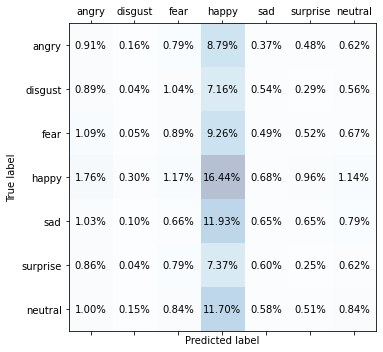

In [104]:
# Show only the best one 
i = 2
confmat = confusion_matrix(y_true=sift_actuals[i], y_pred=sift_predictions[i], labels=targets)
confmat = confmat/np.sum(confmat) * 100
show_confusion_matrix(confmat)

### Parformance matrics & Classification reports

In [118]:
showPerformance(sift_predictions, sift_actuals)

data/sift/sift_bof_100.csv
Precision: 0.133
Recall: 0.143
F1: 0.135
Accuracy: 0.165
Classification reports
              precision    recall  f1-score   support

       angry       0.15      0.14      0.14       957
     disgust       0.03      0.00      0.01       830
        fear       0.13      0.14      0.13      1024
       happy       0.22      0.30      0.26      1773
         sad       0.16      0.20      0.18      1247
    surprise       0.09      0.06      0.08       831
     neutral       0.16      0.15      0.15      1233

    accuracy                           0.16      7895
   macro avg       0.13      0.14      0.14      7895
weighted avg       0.15      0.16      0.15      7895

data/sift/sift_bof_500.csv
Precision: 0.167
Recall: 0.150
F1: 0.134
Accuracy: 0.190
Classification reports
              precision    recall  f1-score   support

       angry       0.13      0.10      0.11       957
     disgust       0.24      0.03      0.06       830
        fear       0.15   

# KNN with KAZE

In [119]:
csv_list = ['data/kaze/kaze_bof_100.csv', 'data/kaze/kaze_bof_500.csv', 'data/kaze/kaze_bof_1000.csv', 
            'data/kaze/kaze_pca_bof_100.csv', 'data/kaze/kaze_pca_bof_500.csv', 'data/kaze/kaze_pca_bof_1000.csv']

In [80]:
kaze_predictions = []
kaze_actuals = []
for i in range(len(csv_list)):
    pred, act = processKNN(csv_list[i], 2)
    kaze_predictions.append(pred)
    kaze_actuals.append(act)

data/kaze/kaze_bof_100.csv
(31284, 99)
(31284,)
(7856, 99)
(7856,)
Test Accuracy: 0.167
data/kaze/kaze_bof_500.csv
(31284, 499)
(31284,)
(7856, 499)
(7856,)
Test Accuracy: 0.173
data/kaze/kaze_bof_1000.csv
(31284, 999)
(31284,)
(7856, 999)
(7856,)
Test Accuracy: 0.170
data/kaze/kaze_pca_bof_100.csv
(31275, 99)
(31275,)
(7853, 99)
(7853,)
Test Accuracy: 0.167
data/kaze/kaze_pca_bof_500.csv
(31275, 499)
(31275,)
(7853, 499)
(7853,)
Test Accuracy: 0.169
data/kaze/kaze_pca_bof_1000.csv
(31275, 999)
(31275,)
(7853, 999)
(7853,)
Test Accuracy: 0.178


## Evaluation

### Confusion matrix

C:\Users\CREATE\AppData\Local\Temp\ipykernel_11344\3629548759.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + target_labels)
C:\Users\CREATE\AppData\Local\Temp\ipykernel_11344\3629548759.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + target_labels)


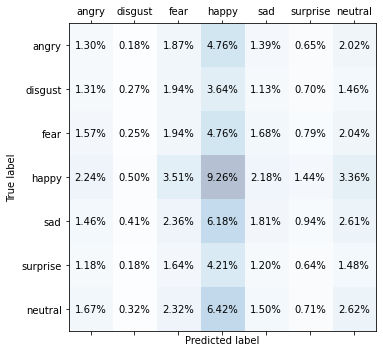

In [130]:
# Show only the best one 
i = 5
confmat = confusion_matrix(y_true=kaze_actuals[i], y_pred=kaze_predictions[i], labels=targets)
confmat = confmat/np.sum(confmat) * 100
show_confusion_matrix(confmat)

### Parformance matrics & Classification reports

In [120]:
showPerformance(kaze_predictions, kaze_actuals)

data/kaze/kaze_bof_100.csv
Precision: 0.150
Recall: 0.144
F1: 0.139
Accuracy: 0.167
Classification reports
              precision    recall  f1-score   support

       angry       0.11      0.11      0.11       955
     disgust       0.15      0.03      0.05       821
        fear       0.13      0.14      0.14      1022
       happy       0.22      0.34      0.27      1770
         sad       0.16      0.15      0.15      1237
    surprise       0.11      0.09      0.10       828
     neutral       0.16      0.14      0.15      1223

    accuracy                           0.17      7856
   macro avg       0.15      0.14      0.14      7856
weighted avg       0.16      0.17      0.16      7856

data/kaze/kaze_bof_500.csv
Precision: 0.165
Recall: 0.144
F1: 0.136
Accuracy: 0.173
Classification reports
              precision    recall  f1-score   support

       angry       0.12      0.12      0.12       955
     disgust       0.28      0.03      0.05       821
        fear       0.12   

# KNN with ORB

In [127]:
csv_list = ['data/orb/orb_bof_100.csv', 'data/orb/orb_bof_500.csv', 'data/orb/orb_bof_1000.csv', 
            'data/orb/orb_pca_bof_100.csv', 'data/orb/orb_pca_bof_500.csv', 'data/orb/orb_pca_bof_1000.csv']

In [82]:
orb_predictions = []
orb_actuals = []
for i in range(len(csv_list)):
    pred, act = processKNN(csv_list[i], 2)
    orb_predictions.append(pred)
    orb_actuals.append(act)

data/orb/orb_bof_100.csv
(31430, 99)
(31430,)
(7896, 99)
(7896,)
Test Accuracy: 0.155
data/orb/orb_bof_500.csv
(31430, 499)
(31430,)
(7896, 499)
(7896,)
Test Accuracy: 0.136
data/orb/orb_bof_1000.csv
(31430, 999)
(31430,)
(7896, 999)
(7896,)
Test Accuracy: 0.129
data/orb/orb_pca_bof_100.csv
(31400, 99)
(31400,)
(7890, 99)
(7890,)
Test Accuracy: 0.166
data/orb/orb_pca_bof_500.csv
(31400, 499)
(31400,)
(7890, 499)
(7890,)
Test Accuracy: 0.163
data/orb/orb_pca_bof_1000.csv
(31400, 999)
(31400,)
(7890, 999)
(7890,)
Test Accuracy: 0.175


## Evaluation

### Confusion matrix

C:\Users\CREATE\AppData\Local\Temp\ipykernel_11344\3629548759.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + target_labels)
C:\Users\CREATE\AppData\Local\Temp\ipykernel_11344\3629548759.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + target_labels)


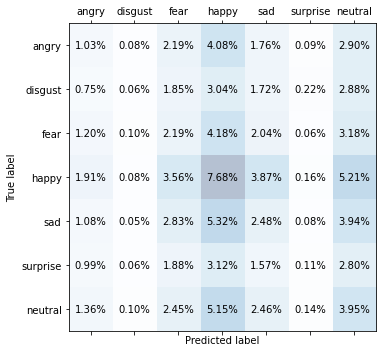

In [131]:
# Show only the best one 
i = 5
confmat = confusion_matrix(y_true=orb_actuals[i], y_pred=orb_predictions[i], labels=targets)
confmat = confmat/np.sum(confmat) * 100
show_confusion_matrix(confmat)

### Parformance matrics & Classification reports

In [128]:
showPerformance(orb_predictions, orb_actuals)

data/orb/orb_bof_100.csv
Precision: 0.135
Recall: 0.136
F1: 0.131
Accuracy: 0.155
Classification reports
              precision    recall  f1-score   support

       angry       0.11      0.08      0.10       957
     disgust       0.11      0.06      0.07       830
        fear       0.09      0.07      0.08      1024
       happy       0.21      0.24      0.23      1774
         sad       0.17      0.14      0.15      1247
    surprise       0.09      0.08      0.08       831
     neutral       0.16      0.29      0.20      1233

    accuracy                           0.15      7896
   macro avg       0.13      0.14      0.13      7896
weighted avg       0.15      0.15      0.15      7896

data/orb/orb_bof_500.csv
Precision: 0.171
Recall: 0.147
F1: 0.085
Accuracy: 0.136
Classification reports
              precision    recall  f1-score   support

       angry       0.14      0.05      0.07       957
     disgust       0.29      0.01      0.02       830
        fear       0.13      0

C:\Users\CREATE\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\CREATE\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\CREATE\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\CREATE\anaconda3\lib\site-packages\sklearn\metrics\_clas

Accuracy: 0.166
Classification reports
              precision    recall  f1-score   support

       angry       0.12      0.17      0.14       957
     disgust       0.09      0.02      0.03       830
        fear       0.14      0.12      0.13      1023
       happy       0.23      0.33      0.27      1773
         sad       0.16      0.17      0.16      1245
    surprise       0.09      0.04      0.05       831
     neutral       0.14      0.16      0.15      1231

    accuracy                           0.17      7890
   macro avg       0.14      0.14      0.13      7890
weighted avg       0.15      0.17      0.15      7890

data/orb/orb_pca_bof_500.csv
Precision: 0.150
Recall: 0.145
F1: 0.141
Accuracy: 0.163
Classification reports
              precision    recall  f1-score   support

       angry       0.11      0.11      0.11       957
     disgust       0.15      0.03      0.05       830
        fear       0.13      0.20      0.16      1023
       happy       0.23      0.28     

# KNN with BRISK

In [129]:
csv_list = ['data/brisk/brisk_bof_100.csv', 'data/brisk/brisk_bof_500.csv', 'data/brisk/brisk_bof_1000.csv', 
            'data/brisk/brisk_pca_bof_100.csv', 'data/brisk/brisk_pca_bof_500.csv', 'data/brisk/brisk_pca_bof_1000.csv']

In [84]:
brisk_predictions = []
brisk_actuals = []
for i in range(len(csv_list)):
    pred, act = processKNN(csv_list[i], 2)
    brisk_predictions.append(pred)
    brisk_actuals.append(act)

data/brisk/brisk_bof_100.csv
(30833, 99)
(30833,)
(7731, 99)
(7731,)
Test Accuracy: 0.176
data/brisk/brisk_bof_500.csv
(30833, 499)
(30833,)
(7731, 499)
(7731,)
Test Accuracy: 0.183
data/brisk/brisk_bof_1000.csv
(30833, 999)
(30833,)
(7731, 999)
(7731,)
Test Accuracy: 0.171
data/brisk/brisk_pca_bof_100.csv
(8004, 99)
(8004,)
(2160, 99)
(2160,)
Test Accuracy: 0.193
data/brisk/brisk_pca_bof_500.csv
(8004, 499)
(8004,)
(2160, 499)
(2160,)
Test Accuracy: 0.167
data/brisk/brisk_pca_bof_1000.csv
(8004, 999)
(8004,)
(2160, 999)
(2160,)
Test Accuracy: 0.172


## Evaluation

### Confusion matrix

C:\Users\CREATE\AppData\Local\Temp\ipykernel_11344\3629548759.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + target_labels)
C:\Users\CREATE\AppData\Local\Temp\ipykernel_11344\3629548759.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + target_labels)


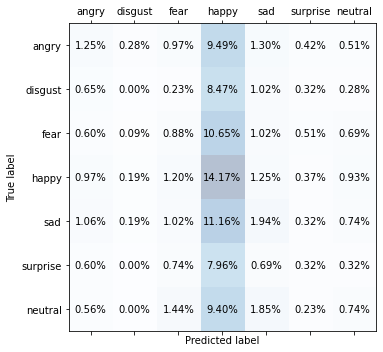

In [132]:
# Show only the best one 
i = 3
confmat = confusion_matrix(y_true=brisk_actuals[i], y_pred=brisk_predictions[i], labels=targets)
confmat = confmat/np.sum(confmat) * 100
show_confusion_matrix(confmat)

### Parformance matrics & Classification reports

In [133]:
showPerformance(brisk_predictions, brisk_actuals)

data/brisk/brisk_bof_100.csv
Precision: 0.139
Recall: 0.142
F1: 0.129
Accuracy: 0.176
Classification reports
              precision    recall  f1-score   support

       angry       0.12      0.10      0.11       942
     disgust       0.06      0.01      0.02       814
        fear       0.13      0.13      0.13      1001
       happy       0.22      0.44      0.30      1741
         sad       0.16      0.18      0.17      1200
    surprise       0.13      0.05      0.07       823
     neutral       0.15      0.07      0.10      1210

    accuracy                           0.18      7731
   macro avg       0.14      0.14      0.13      7731
weighted avg       0.15      0.18      0.15      7731

data/brisk/brisk_bof_500.csv
Precision: 0.153
Recall: 0.145
F1: 0.127
Accuracy: 0.183
Classification reports
              precision    recall  f1-score   support

       angry       0.13      0.09      0.11       942
     disgust       0.14      0.03      0.05       814
        fear       0.1

# KNN with AKAZE

In [134]:
csv_list = ['data/akaze/akaze_bof_100.csv', 'data/akaze/akaze_bof_500.csv', 'data/akaze/akaze_bof_1000.csv', 
            'data/akaze/akaze_pca_bof_100.csv', 'data/akaze/akaze_pca_bof_500.csv', 'data/akaze/akaze_pca_bof_1000.csv']

In [86]:
akaze_predictions = []
akaze_actuals = []
for i in range(len(csv_list)):
    pred, act = processKNN(csv_list[i], 2)
    akaze_predictions.append(pred)
    akaze_actuals.append(act)

data/akaze/akaze_bof_100.csv
(31332, 99)
(31332,)
(7862, 99)
(7862,)
Test Accuracy: 0.161
data/akaze/akaze_bof_500.csv
(31332, 499)
(31332,)
(7862, 499)
(7862,)
Test Accuracy: 0.169
data/akaze/akaze_bof_1000.csv
(31332, 999)
(31332,)
(7862, 999)
(7862,)
Test Accuracy: 0.186
data/akaze/akaze_pca_bof_100.csv
(25314, 99)
(25314,)
(6606, 99)
(6606,)
Test Accuracy: 0.204
data/akaze/akaze_pca_bof_500.csv
(25314, 499)
(25314,)
(6606, 499)
(6606,)
Test Accuracy: 0.204
data/akaze/akaze_pca_bof_1000.csv
(25314, 999)
(25314,)
(6606, 999)
(6606,)
Test Accuracy: 0.194


## Evaluation

### Confusion matrix

C:\Users\CREATE\AppData\Local\Temp\ipykernel_11344\3629548759.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + target_labels)
C:\Users\CREATE\AppData\Local\Temp\ipykernel_11344\3629548759.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + target_labels)


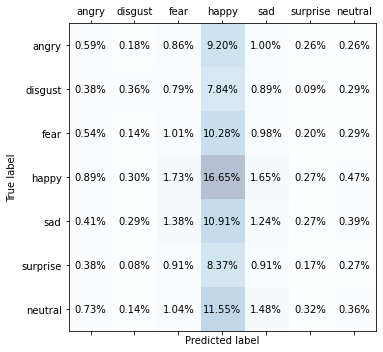

In [135]:
# Show only the best one 
i = 4
confmat = confusion_matrix(y_true=akaze_actuals[i], y_pred=akaze_predictions[i], labels=targets)
confmat = confmat/np.sum(confmat) * 100
show_confusion_matrix(confmat)

### Parformance matrics & Classification reports

In [136]:
showPerformance(akaze_predictions, akaze_actuals)

data/akaze/akaze_bof_100.csv
Precision: 0.134
Recall: 0.138
F1: 0.131
Accuracy: 0.161
Classification reports
              precision    recall  f1-score   support

       angry       0.12      0.12      0.12       954
     disgust       0.06      0.01      0.02       822
        fear       0.12      0.12      0.12      1022
       happy       0.21      0.30      0.25      1766
         sad       0.16      0.22      0.19      1237
    surprise       0.11      0.06      0.07       831
     neutral       0.16      0.14      0.15      1230

    accuracy                           0.16      7862
   macro avg       0.13      0.14      0.13      7862
weighted avg       0.15      0.16      0.15      7862

data/akaze/akaze_bof_500.csv
Precision: 0.137
Recall: 0.138
F1: 0.124
Accuracy: 0.169
Classification reports
              precision    recall  f1-score   support

       angry       0.12      0.12      0.12       954
     disgust       0.04      0.01      0.01       822
        fear       0.1

# KNN with HoG

In [9]:
csv_list = ['data/hog/hog_data.csv', 'data/hog/hog_scaled.csv']

In [10]:
hog_predictions = []
hog_actuals = []
for i in range(len(csv_list)):
    pred, act = processKNN(csv_list[i], 3)
    hog_predictions.append(pred)
    hog_actuals.append(act)

data/hog/hog_data.csv
(31432, 2304)
(31432,)
(7896, 2304)
(7896,)
Test Accuracy: 0.411
data/hog/hog_scaled.csv
(31432, 2304)
(31432,)
(7896, 2304)
(7896,)
Test Accuracy: 0.225


## Evaluation

### Confusion matrix

C:\Users\CREATE\AppData\Local\Temp\ipykernel_3524\3629548759.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + target_labels)
C:\Users\CREATE\AppData\Local\Temp\ipykernel_3524\3629548759.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + target_labels)


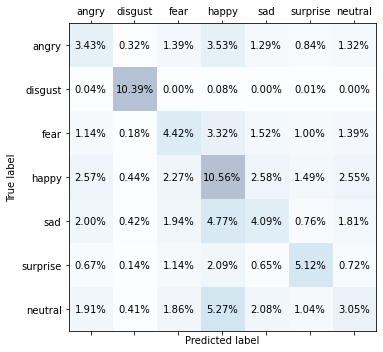

In [11]:
# Show only the best one 
i = 0
confmat = confusion_matrix(y_true=hog_actuals[i], y_pred=hog_predictions[i], labels=targets)
confmat = confmat/np.sum(confmat) * 100
show_confusion_matrix(confmat)

### Parformance matrics & Classification reports

In [12]:
showPerformance(hog_predictions, hog_actuals)

data/hog/hog_data.csv
Precision: 0.421
Recall: 0.432
F1: 0.423
Accuracy: 0.411
Classification reports
              precision    recall  f1-score   support

       angry       0.29      0.28      0.29       957
     disgust       0.85      0.99      0.91       830
        fear       0.34      0.34      0.34      1024
       happy       0.36      0.47      0.41      1774
         sad       0.34      0.26      0.29      1247
    surprise       0.50      0.49      0.49       831
     neutral       0.28      0.20      0.23      1233

    accuracy                           0.41      7896
   macro avg       0.42      0.43      0.42      7896
weighted avg       0.40      0.41      0.40      7896

data/hog/hog_scaled.csv
Precision: 0.032
Recall: 0.143
F1: 0.052
Accuracy: 0.225
Classification reports
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00       957
     disgust       0.00      0.00      0.00       830
        fear       0.00      0.00 

C:\Users\CREATE\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\CREATE\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\CREATE\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\CREATE\anaconda3\lib\site-packages\sklearn\metrics\_clas

# Benchmark

## Find out best parameter for benchmark

In [17]:
# Use original dataset 
df = pd.read_csv('data/fer_data.csv')
df.head()

,usage,emotion,pixels
0,train,3,108 83 63 65 89 111 121 121 125 111 103 105 11...
1,train,3,137 142 159 162 158 134 113 167 174 177 164 12...
2,train,3,111 148 155 167 181 191 194 193 195 199 203 20...
3,train,3,151 156 121 100 80 116 151 169 183 185 192 190...
4,train,3,248 187 149 130 97 140 139 117 197 251 231 255...


In [19]:
df_train = df[df['usage']=='train']
df_test = df[df['usage']=='test']
train_data, train_scaled = load_data(df_train, 0)
train_target = list(df_train.emotion)
test_data, test_scaled = load_data(df_test, 0)
test_target = list(df_test.emotion)

In [20]:
X_train = np.array(train_data)
y_train = np.array(train_target)
X_test = np.array(test_data)
y_test = np.array(test_target)

In [22]:
# Check which strategy make is best
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.2295113260371596

In [23]:
dummy.score(X_test, y_test)

0.2246707193515704

In [24]:
dummy = DummyClassifier(strategy='prior')
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.2295113260371596

In [25]:
dummy.score(X_test, y_test)

0.2246707193515704

In [26]:
dummy = DummyClassifier(strategy='stratified')
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.15465131076609825

In [27]:
dummy.score(X_test, y_test)

0.15767477203647418

In [28]:
dummy = DummyClassifier(strategy='uniform', random_state=1)
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.14167090862814966

In [29]:
dummy.score(X_test, y_test)

0.1469098277608916

In [30]:
dummy = DummyClassifier(strategy='constant', constant=1)
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.10085263425808094

In [31]:
dummy.score(X_test, y_test)

0.10511651469098278

Most_frequent or prior are best for strategy parameter.

## Check with Best PCA data

In [32]:
df = pd.read_csv('data/pca/fer_pca_inverse.csv')
df.head()

,usage,emotion,pca
0,train,3,103 107 99 91 90 94 100 103 103 103 103 107 11...
1,train,3,147 149 148 148 149 152 153 152 151 150 150 14...
2,train,3,107 119 134 152 173 186 193 196 196 198 198 20...
3,train,3,146 145 133 122 116 123 141 165 186 201 208 20...
4,train,3,220 202 169 130 98 91 105 133 159 175 186 185 ...


In [33]:
df_train = df[df['usage']=='train']
df_test = df[df['usage']=='test']
train_data, train_scaled = load_data(df_train, 1)
train_target = list(df_train.emotion)
test_data, test_scaled = load_data(df_test, 1)
test_target = list(df_test.emotion)

In [34]:
X_train = np.array(train_data)
y_train = np.array(train_target)
X_test = np.array(test_data)
y_test = np.array(test_target)

In [35]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.2295113260371596

In [36]:
dummy.score(X_test, y_test)

0.2246707193515704

## Check with Best LDA data

In [37]:
df = pd.read_csv('data/lda/fer_lda_std.csv')
df.head()

,usage,emotion,lda
0,train,3,0.7894818314647534 0.2147150019296881 -0.87952...
1,train,3,0.6069599043975686 -0.20427589187483838 0.2641...
2,train,3,-0.2795828858633714 1.0125084423693098 -0.1462...
3,train,3,-0.12393359351771732 0.4088989785758754 -1.315...
4,train,3,-0.14131908024016165 1.0288778060846748 -0.484...


In [39]:
df_train = df[df['usage']=='train']
df_test = df[df['usage']=='test']
train_data, train_scaled = load_data(df_train, 4)
train_target = list(df_train.emotion)
test_data, test_scaled = load_data(df_test, 4)
test_target = list(df_test.emotion)

In [40]:
X_train = np.array(train_data)
y_train = np.array(train_target)
X_test = np.array(test_data)
y_test = np.array(test_target)

In [41]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.2295113260371596

In [42]:
dummy.score(X_test, y_test)

0.2246707193515704

## Check with best BoF

In [43]:
df = pd.read_csv('data/sift/sift_bof_100.csv')
df.head()

,usage,emotion,histogram
0,train,3,0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1,train,3,0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 ...
2,train,3,1 2 0 0 0 0 0 0 1 1 2 0 0 0 0 0 0 0 1 0 0 1 0 ...
3,train,3,0 0 0 0 1 0 0 0 0 0 0 2 0 0 0 0 1 0 0 0 0 1 0 ...
4,train,3,0 1 2 0 1 0 1 0 0 0 0 1 0 1 1 0 0 3 0 0 0 1 0 ...


In [47]:
df_train = df[df['usage']=='train']
df_test = df[df['usage']=='test']
train_data, train_scaled = load_data(df_train, 2)
train_target = list(df_train.emotion)
test_data, test_scaled = load_data(df_test, 2)
test_target = list(df_test.emotion)

In [44]:
X_train = np.array(train_data)
y_train = np.array(train_target)
X_test = np.array(test_data)
y_test = np.array(test_target)

In [45]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.2295113260371596

In [46]:
dummy.score(X_test, y_test)

0.2246707193515704

## Check with best HoG

In [47]:
df = pd.read_csv('data/hog/hog_data.csv')
df.head()

,usage,emotion,hog
0,train,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1,train,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
2,train,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
3,train,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
4,train,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


In [49]:
df_train = df[df['usage']=='train']
df_test = df[df['usage']=='test']
train_data, train_scaled = load_data(df_train, 3)
train_target = list(df_train.emotion)
test_data, test_scaled = load_data(df_test, 3)
test_target = list(df_test.emotion)

In [50]:
X_train = np.array(train_data)
y_train = np.array(train_target)
X_test = np.array(test_data)
y_test = np.array(test_target)

In [51]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.2295113260371596

In [52]:
dummy.score(X_test, y_test)

0.2246707193515704

# Get better result

## Hyper parameter tuning

Use PCA inverse data

In [4]:
df = pd.read_csv('data/lda/fer_lda_std.csv')
df.head()

,usage,emotion,lda
0,train,3,0.7894818314647534 0.2147150019296881 -0.87952...
1,train,3,0.6069599043975686 -0.20427589187483838 0.2641...
2,train,3,-0.2795828858633714 1.0125084423693098 -0.1462...
3,train,3,-0.12393359351771732 0.4088989785758754 -1.315...
4,train,3,-0.14131908024016165 1.0288778060846748 -0.484...


In [5]:
df_train = df[df['usage']=='train']
df_test = df[df['usage']=='test']
train_data, train_scaled = load_data(df_train, 4)
train_target = list(df_train.emotion)
test_data, test_scaled = load_data(df_test, 4)
test_target = list(df_test.emotion)

In [6]:
X_train = np.array(train_data)
y_train = np.array(train_target)
X_test = np.array(test_data)
y_test = np.array(test_target)

In [ ]:
param_grid = [{'n_neighbors': [3, 5, 10, 15, 20],
               'weights': ['uniform', 'distance'], 
               'metric': ['minkowski', 'euclidean', 'manhattan']}]

knn = KNN()

gs = GridSearchCV(estimator=knn, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  refit=True,
                  cv=10,
                  n_jobs=-1)
clf = gs.fit(X_train, y_train)

In [ ]:
print(clf.best_score_)
print(clf.best_params_)
result = clf.best_estimator_
print('Test accuracy: %.3f' % result.score(X_test, y_test))

## K-fold cross-validation

In [ ]:
knn = KNN(n_neighbors=3, weights='distance', metric='minkowski')
scores = cross_val_score(estimator=knn,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

# Visualizing learning curves and validation curves

In [7]:
knn = KNN(n_neighbors=3, weights='distance', metric='minkowski')

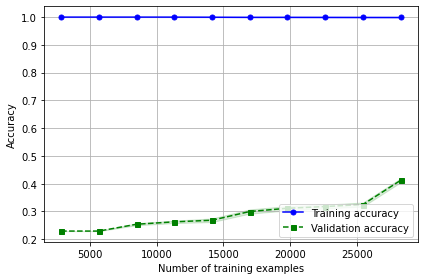

In [8]:
train_sizes, train_scores, test_scores =\
                learning_curve(estimator=knn,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

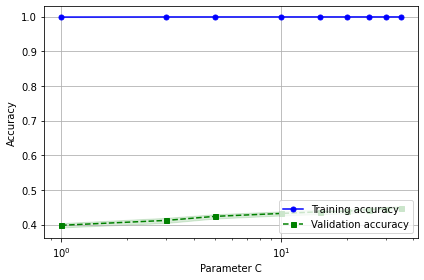

In [9]:
param_range = [1, 3, 5, 10, 15, 20, 25, 30, 35]
train_scores, test_scores = validation_curve(
                estimator=knn, 
                X=X_train, 
                y=y_train, 
                param_name='n_neighbors', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='Training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='Validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

# Plotting a receiver operating characteristic

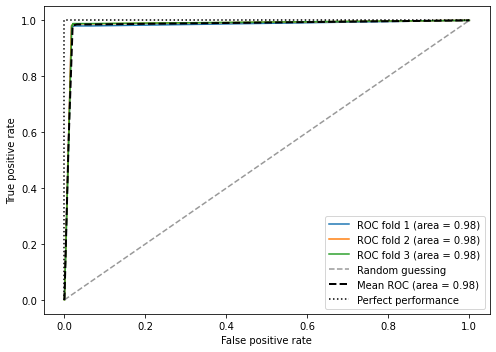

In [17]:
X_train2 = X_train[:, [0, 5]]
    
cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = knn.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()